In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [7]:
dataset=tf.keras.preprocessing.image_dataset_from_directory (
    "PlantVillage",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [9]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(dataset)

68

it is showing 68 because, every element in the dataset is a bacth of 32 images
32*68=2176
the last bacth is not perfect

In [33]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch[0].numpy())

(32, 256, 256, 3)
2


so here image_batch stores all the images label_batch stores all the labels of those images

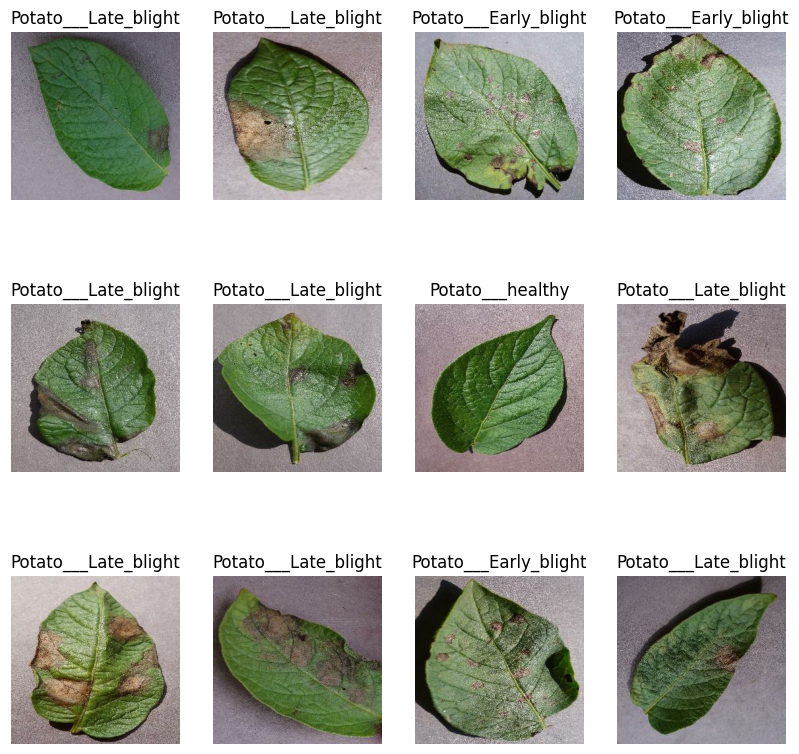

In [37]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

This line of code creates a grid of subplots with 3 rows and 4 columns (total of 12 subplots). The third argument i+1 specifies the index of the current subplot within the grid. Since i ranges from 0 to 11 (inclusive), i+1 ranges from 1 to 12, corresponding to the index of each subplot in the grid.

In [39]:
len(dataset)

68

80% = training
20% = 10% validation, 10% test 

In [40]:
train_size =0.8
len(dataset)*train_size

54.400000000000006

In [42]:
train_DS= dataset.take(54)
len(train_DS)

54

In [44]:
test_DS= dataset.skip(54)
len(test_DS)

14

arr[54:]: this 54 onwards, arr[:54]: this is first 54

In [45]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [47]:
Val_DS=dataset.take(6)
len(Val_DS)

6

In [48]:
test_DS=test_DS.skip(6)
len(test_DS)

8

In [58]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_DS=ds.take(train_size)
    Val_DS= ds.skip(train_size).take(val_size)
    test_DS= ds.skip(train_size).skip(val_size)
    return train_DS, Val_DS, test_DS

In [60]:
train_DS, Val_DS, test_DS = get_dataset_partitions_tf(dataset)
len(train_DS)

54

In [63]:
train_DS=train_DS.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
Val_DS=Val_DS.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_DS= test_DS.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

it will read the image, next time when you need the image, it will keep the image i memory, improve the performmance of the pipeline

0 TO 255 is the RGB scle, if we divide the by 255 we get a number between 0 and 1

In [64]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

tf.keras.sequential is used in resizing and rescaling

data augmentation is used to make the model Robust 

In [65]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

Build model: CNN

In [ ]:
input_shape=IMAGE_SIZE,IMAGE_SIZE
model=models.Sequential([
    resize_and_rescale, data_augmentation, layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling((2,2)),
])

Here (3,3) is filter size
Max pooling size (2,2) is 2 by 2 box, and it pulls the highest pixel in every 2/2 box and create a high pixel 2/2 box at the end 
relu is faster to compute and activation layer for hidden layers is relu
I should learn about neuron and CNN 